## CNN Neural Network (Manual) For Cancerous and Non-Cancerous Cell Classification

In [3]:
# minimal imports necessary for our manual implementation of CNN
import numpy as np
import pandas as pd
import cv2

## Preprocessing Data

In [4]:
# Sources:
# Source - https://stackoverflow.com/a
# Posted by Usama Aleem
# Retrieved 2025-11-26, License - CC BY-SA 4.0
# Used for saving images

# https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c
# used to understand best image preprocessing practices
import os, sys
import matplotlib.pyplot as plt

'''
Converting images in the directory to .npy format for usability in CNN model.
We first load the image with cv2, grayscale it, then resize the image to a 
(128, 128) shape (for faster training). We then save these images to a directory called
smaller_cnn_data.

'''

def preprocess_images(chosen_dir: str):
    path = '../data/cancer_dataset/lung_colon_image_set/'
    path = path+chosen_dir
    dirs = os.listdir( path )
    dirs.sort()
    for item in dirs:
        image = cv2.imread(path+item)
        image = cv2.resize(image, (128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # create the directory where the data will be stored
        dest_dir = os.path.join('smaller_cnn_data', chosen_dir)
        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)

# do not run these, files already created
# preprocess_images('colon_image_sets/colon_aca/')
# preprocess_images('colon_image_sets/colon_n/')
# preprocess_images('lung_image_sets/lung_aca/')
# preprocess_images('lung_image_sets/lung_n/')
# preprocess_images('lung_image_sets/lung_scc/')



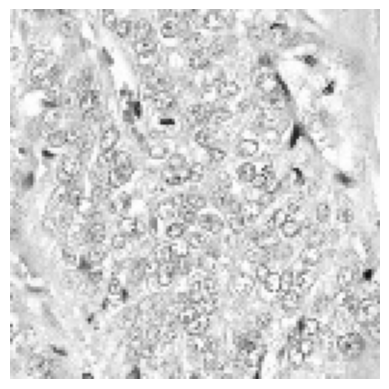

In [5]:
# Ensure images are properly printed out
img = cv2.imread('smaller_cnn_data/colon_image_sets/colon_aca/colonca1.jpeg')
plt.imshow(img)
plt.axis('off') 
plt.show()

In [6]:
# split the testing, validation, and training data
# read the data then split based on 
import math
import random

'''
Split the data into separate folders. 70% used for training, 15% used for validation, and
the last 15% used for testing. Images from the smaller_cnn_data are randomly shuffled, and 
images are then copied to the model_train_val_test directory based on pre-defined ratios.
'''
def split_data(subdir: str, train_ratio=0.7, val_ratio=0.15):
    path = os.path.join('smaller_cnn_data/', subdir)
    dirs = os.listdir( path )
    i = 0
    random.shuffle(dirs)
    img_count = len(dirs)
    train_count = math.floor(img_count * train_ratio)
    val_count = train_count + math.floor(img_count * val_ratio)
    for item in dirs:
        image = cv2.imread(os.path.join(path, item))
        if image is None:
            print("Couldn't read:", item)
            continue
        dest_subdir = os.path.basename(os.path.normpath(path))
        if i < train_count:
            dest_dir = os.path.join('model_train_val_test/train/', dest_subdir)
        elif i < val_count:
            dest_dir = os.path.join('model_train_val_test/val/', dest_subdir)
        else:
            dest_dir = os.path.join('model_train_val_test/test/', dest_subdir)

        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)
        i = i + 1

# split_data('colon_image_sets/colon_aca/')
# split_data('colon_image_sets/colon_n/')
# split_data('lung_image_sets/lung_aca/')
# split_data('lung_image_sets/lung_n/')
# split_data('lung_image_sets/lung_scc/')

## Construct the CNN Training Model

Create training for our model: One for Binary classification, and one for Multiclass classification

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras.losses import binary_crossentropy
from keras.losses import categorical_crossentropy

In [6]:
# Creating the categorical classification model

In [74]:
# to build a CNN with multiple Convolutional Layers
# We use 3 x 3 kernels for every convolutional layers, 
# and double filters every layer. Padding is added to 
# capture details of edges. Pooling layers are
# are always a size of 2 with a stride of 2, to caputre patterns and
# reduce dimensionality. Finally, we flatten for the Dense layers,
# and output results of the final Dense layer to the output layer

# since this is the categorical, softmax is used

train_dataset = keras.utils.image_dataset_from_directory(
    'model_train_val_test/train/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
).prefetch(tf.data.AUTOTUNE)

val_dataset = keras.utils.image_dataset_from_directory(
    'model_train_val_test/val/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
).prefetch(tf.data.AUTOTUNE)

test_dataset = keras.utils.image_dataset_from_directory(
    'model_train_val_test/test/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Image data shape', images.shape)
    print('Classification Labels shape', labels.shape)

# Source of reference: https://www.tensorflow.org/tutorials/images/cnn (Tensorflow CNN tutorial)
model = Sequential([
    keras.Input(shape=(128, 128, 1), batch_size=32),
    keras.layers.Rescaling(1./255),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),    # same shape as original picture
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
], name="model")



Found 17500 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.
Image data shape (32, 128, 128, 1)
Classification Labels shape (32, 5)


In [75]:
# compile the model
model.compile(optimizer=SGD(),
              loss=categorical_crossentropy,
              metrics=['accuracy', 'precision', 'recall', 'AUC'])

In [76]:
# get the summary of the model.
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (32, 128, 128, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 126, 126, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 63, 63, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 61, 61, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 30, 30, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 28, 28, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 128)              │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,637 (6.25 MB)

 Trainable params: 1,637,637 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# now fit the model
history = model.fit(train_dataset, batch_size=32, epochs=100, validation_data=val_dataset)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - AUC: 0.5835 - accuracy: 0.2520 - loss: 1.5785 - precision: 0.5208 - recall: 0.0014 - val_AUC: 0.8549 - val_accuracy: 0.4885 - val_loss: 1.3490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - AUC: 0.7375 - accuracy: 0.3662 - loss: 1.3719 - precision: 0.5229 - recall: 0.0881 - val_AUC: 0.8764 - val_accuracy: 0.6160 - val_loss: 1.0907 - val_precision: 0.9541 - val_recall: 0.0499
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - AUC: 0.8153 - accuracy: 0.4490 - loss: 1.1696 - precision: 0.5701 - recall: 0.1974 - val_AUC: 0.8860 - val_accuracy: 0.6197 - val_loss: 0.9560 - val_precision: 0.9145 - val_recall: 0.0827
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 0.8504 - accuracy: 0.5054 - loss: 1.0570 - precision: 0.5965 - recall: 0.2681 - val_AUC: 0.9114 - val_accuracy: 0.6757 - val_loss: 0.8199 - val_precision: 0.8079 - val_recall: 0.3331
Epoch 5/100


In [ ]:
# # save the model
# model.save('models/categorical_cnn.keras')

In [ ]:
# used for metrics, in case kernel restarted
from keras.models import load_model
model = load_model('models/categorical_cnn.keras')

NameError: name 'load_model' is not defined

In [79]:
loss, accuracy, precision, recall, auc = model.evaluate(test_dataset)
f1 = (2 * precision * recall) / (precision + recall)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {auc:.4f}')
print(f'Test f1Score: {f1:4f}')

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - AUC: 0.9984 - accuracy: 0.9603 - loss: 0.1033 - precision: 0.9615 - recall: 0.9600
Test Loss: 0.1033
Test Accuracy: 0.9603
Test Precision: 0.9615
Test Recall: 0.9984
Test f1Score: 0.960769


## Results and Overfitting Plots

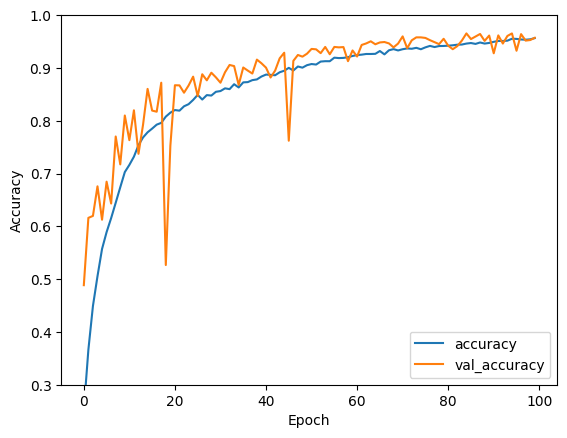

In [80]:
# print the training accuracy and val accuracy over each other (cannot do this with load model)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

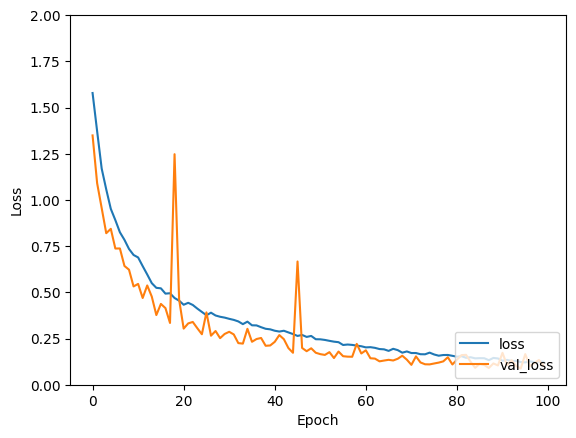

In [81]:
# print the training loss and val loss over each other (cannot do this with load model)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [ ]:
import math
import random

'''
Split the data for the binary model, using the same method as the categorical model.
This time, only for binary classification.
'''
def split_data_binary(subdir: str, dest_subdir: str, train_ratio=0.7, val_ratio=0.15):
    path = os.path.join('smaller_cnn_data/', subdir)
    dirs = os.listdir( path )
    dirs.sort()
    i = 0
    random.shuffle(dirs)
    img_count = len(dirs)
    train_count = math.floor(img_count * train_ratio)
    val_count = train_count + math.floor(img_count * val_ratio)
    for item in dirs:
        image = cv2.imread(os.path.join(path, item))
        if image is None:
            print("Couldn't read:", item)
            continue
        if i < train_count:
            dest_dir = os.path.join('binary_train_val_test/train/', dest_subdir)
        elif i < val_count:
            dest_dir = os.path.join('binary_train_val_test/val/', dest_subdir)
        else:
            dest_dir = os.path.join('binary_train_val_test/test/', dest_subdir)

        os.makedirs(dest_dir, exist_ok=True)
        out_path = os.path.join(dest_dir, item)
        cv2.imwrite(out_path, image)
        i = i + 1

# split_data_binary('colon_image_sets/colon_aca/', 'cancerous')
# split_data_binary('colon_image_sets/colon_n/', 'non-cancerous')
# split_data_binary('lung_image_sets/lung_aca/', 'cancerous')
# split_data_binary('lung_image_sets/lung_n/', 'non-cancerous')
# split_data_binary('lung_image_sets/lung_scc/', 'cancerous')

In [15]:
# create a binary classification model, can we detect cancer in general?

# We are using the same CNN architecture as the categorical

bin_train_dataset = keras.utils.image_dataset_from_directory(
    'binary_train_val_test/train/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='binary',
).prefetch(tf.data.AUTOTUNE)

bin_val_dataset = keras.utils.image_dataset_from_directory(
    'binary_train_val_test/val/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='binary',
).prefetch(tf.data.AUTOTUNE)

bin_test_dataset = keras.utils.image_dataset_from_directory(
    'binary_train_val_test/test/',
    image_size=(128,128),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    labels='inferred',
    label_mode='binary',
).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Image data shape', images.shape)
    print('Classification Labels shape', labels.shape)

# Source of reference: https://www.tensorflow.org/tutorials/images/cnn (Tensorflow CNN tutorial)
bin_model = Sequential([
    keras.Input(shape=(128, 128, 1), batch_size=32),
    keras.layers.Rescaling(1./255),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),    # same shape as original picture
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
], name="model")



Found 17500 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Image data shape (32, 128, 128, 1)
Classification Labels shape (32, 5)


In [17]:
# compile the model
bin_model.compile(optimizer=SGD(),
              loss=binary_crossentropy,
              metrics=['accuracy', 'precision', 'recall', 'AUC'])

In [137]:
# now fit the model
bin_history = bin_model.fit(bin_train_dataset, batch_size=32, epochs=100, validation_data=bin_val_dataset)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - AUC: 0.4851 - accuracy: 0.5967 - loss: 0.6785 - precision: 0.4147 - recall: 0.0201 - val_AUC: 0.6181 - val_accuracy: 0.6000 - val_loss: 0.6723 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - AUC: 0.6060 - accuracy: 0.6077 - loss: 0.6609 - precision: 0.5860 - recall: 0.0657 - val_AUC: 0.7239 - val_accuracy: 0.6000 - val_loss: 0.6539 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - AUC: 0.6674 - accuracy: 0.6223 - loss: 0.6303 - precision: 0.5431 - recall: 0.3511 - val_AUC: 0.7340 - val_accuracy: 0.6715 - val_loss: 0.6031 - val_precision: 0.6279 - val_recall: 0.4387
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - AUC: 0.6874 - accuracy: 0.6309 - loss: 0.6111 - precision: 0.5532 - recall: 0.4016 - val_AUC: 0.7425 - val_accuracy: 0.6600 - val_loss: 0.5691 - val_precision: 0.5926 - val_recall: 0.4800
Epoc

In [ ]:
# load the model
from keras.models import load_model
bin_model = load_model('models/binary_cnn.keras')

2.20.0


In [58]:
bin_loss, bin_accuracy, bin_precision, bin_recall, bin_auc = bin_model.evaluate(bin_test_dataset)
bin_f1 = (2 * bin_precision * bin_recall) / (bin_precision + bin_recall)
print(f'Test Loss: {bin_loss:.4f}')
print(f'Test Accuracy: {bin_accuracy:.4f}')
print(f'Test Precision: {bin_precision:.4f}')
print(f'Test Recall: {bin_recall:.4f}')
print(f'Test f1Score: {bin_f1:4f}')


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.9997 - accuracy: 0.9904 - loss: 0.0253 - precision: 0.9828 - recall: 0.9933
Test Loss: 0.0253
Test Accuracy: 0.9904
Test Precision: 0.9828
Test Recall: 0.9933
Test f1Score: 0.988064


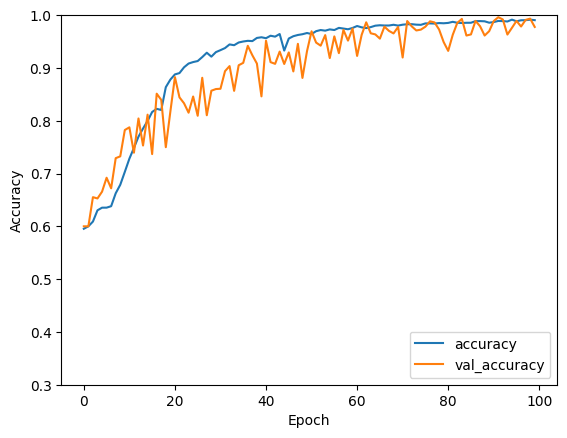

In [25]:
# check for overfitting
# loop through all the weights from the model
# use to predict test data
# calc loss from each set of preds
# plot on top of training loss vs. test loss

# print the training accuracy and val accuracy over each other
plt.plot(bin_history.history['accuracy'], label='accuracy')
plt.plot(bin_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

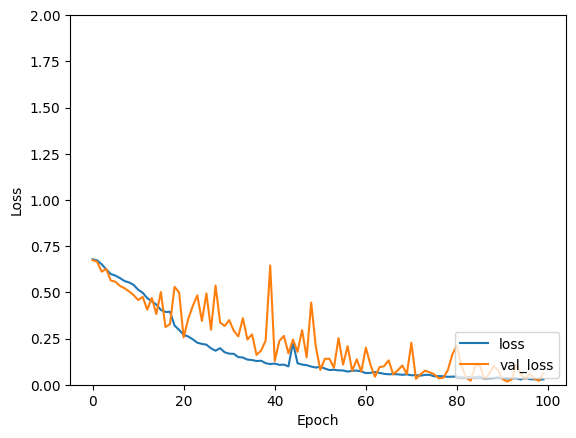

In [26]:
# print the training loss and val loss over each other
plt.plot(bin_history.history['loss'], label='loss')
plt.plot(bin_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

## Image Heatmaps using Grad-CAM (Visual Extension)

In [ ]:
# import cv2
# import numpy as np
# # lets get the grad cam for the categorical model first

# # retrieve last convolutional layer of the model
# last_conv_layer = model.layers[8]
# print(last_conv_layer)

# # retrieve the classification layer of the mode
# classification_layer = model.layers[-1]
# print(classification_layer)

# def get_heatmap_cat(model, img_path):
#     # preprocess the image
#     image = cv2.imread(img_path)
#     image = cv2.resize(image, (128, 128))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     img_array = np.array(image)
#     img_array = np.expand_dims(img_array, axis=0)
#     print(img_array.shape)
#     # get the logits from the last CNN layer
#     # Source: https://www.youtube.com/watch?v=6YZoZ9Vtez0
#     # By Connor Shorten, 2021.
#     # Grad CAM was quite complicated -- needed a tutorial for guidance
    
#     # this model maps inputs to activations of last conv layer
#     logits_layer_model = tf.keras.Model(inputs=model.layers[0].input, outputs=model.get_layer('conv2d_20').output)

#     # map activations of last conv layer to final predictions
#     classification_input = keras.Input(shape=model.layers[8].output.shape[1:])
#     x = classification_input
#     # map to layers after last convolutional layer
#     for layer in model.layers[8:]:
#         x = (layer)(x)
#     classification_model = keras.Model(classification_input, x)

#     # compute gradient of the top predicted class for input image
#     with tf.GradientTape() as tape:
#         # compute activations of last conv layer
#         last_conv_layer_output = logits_layer_model(img_array)
#         tape.watch(last_conv_layer_output)
#         # compute class predictions
#         preds = classification_model(last_conv_layer_output)
#         top_pred_index = tf.argmax(preds[0])
#         top_class_channel = preds[:, top_pred_index]

#     # retrieve the gradient
#     grads = tape.gradient(top_class_channel, last_conv_layer_output)

#     # calculate the mean for pooling
#     pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

#     # multiply each channel in the feature map array
#     last_conv_layer_output = last_conv_layer_output.numpy()[0]
#     pooled_grads = pooled_grads.numpy()
#     for i in range(pooled_grads.shape[-1]):
#         last_conv_layer_output[:, :, i] *= pooled_grads[i]

#     # get the channel-wise mean at the end of the calculation
#     heatmap = np.mean(last_conv_layer_output, axis=1)

#     # normalize the heatmap for displayal
#     heatmap = np.max(heatmap, 0) / np.max(heatmap)
#     return heatmap
    
# heatmap = get_heatmap_cat(model, 'model_train_val_test/test/colon_aca/colonca1.jpeg')
    

<Conv2D name=conv2d_20, built=True>
<Dense name=dense_20, built=True>
(1, 128, 128)


ValueError: Input 0 of layer "conv2d_20" is incompatible with the layer: expected axis -1 of input shape to have value 32, but received input with shape (None, 28, 28, 64)